# AnnDictionary
A package for processing multiple `anndata` objects in parallel with LLMs

# Documentation

Complete documentation covering all functions and modules is available at https://ggit12.github.io/anndictionary. We are actively working to enhance its appearance and improve the overall user experience.


# Citation

If you use this package, please cite:

> #### Benchmarking Cell Type Annotation by Large Language Models with AnnDictionary  
> **George Crowley, Tabula Sapiens Consortium, Stephen R. Quake**  
> *bioRxiv* 2024.10.10.617605  
> [doi: https://doi.org/10.1101/2024.10.10.617605](https://doi.org/10.1101/2024.10.10.617605)



# Install
Copy and paste the code below into a terminal window to install `anndict` in a conda env. It assumes conda is already installed. This should only take a few minutes total.

### Linux
```bash
conda create -n adt python=3.12
conda activate adt
pip install anndict
```

### Mac
```bash
conda create -n adt python=3.12
conda activate adt
conda install -c conda-forge tbb numba
pip install anndict
```

# About
`AnnDictionary` is a package that lets you process multiple `anndata` objects in parallel with a simplified interface (so that you can avoid writing a bunch of for loops). This is accomplished by a dictionary-based wrapping of `scanpy`. We used the package to benchmark cell type annotaiton by 15 LLMs and maintain leaderboard at: https://singlecellgpt.com/celltype-annotation-leaderboard/.

## AI to make things easier
To make it easier to handle basics like cell type annotation for anndatas (one or many), and to make cell type labels agree across multiple anndatas, we provide AI-based processing to handle these tedious tasks. There are also AI-based functions to to biological process inference on gene lists.

These functions include `ai_annotate_cell_type`, `ai_annotate_biological_process`, and `ai_unify_labels`, which all operate over many adata at once.



This package supports many external LLM providers (including OpenAI, Anthropic, Google, and Bedrock). To use these, you'll need an API key. Directions on how to get an OpenAI API key can be found here: https://platform.openai.com/docs/quickstart/account-setup, and for Anthropic, here: https://docs.anthropic.com/en/api/getting-started.

### If you like functions:
The main function in this package is `adata_dict_fapply()` (and its cousin `adata_dict_fapply_return()`, which does the same thing but also returns the result as a dictionary). 

`adata_dict_fapply()` works just like `lapply()` in R. It takes `adata_dict_fapply(adata_dict, func, **kwargs)`. 

- `adata_dict` is a dictionary.
- `func` is a function to apply over each element of the dictionary.
- `**kwargs` are arguments that `func` takes.

You can have `func` take the argument `adt_key` (i.e., `func(adata, adt_key=None)`) if you want the dictionary key to be available within `func`.

The value for any **kwarg can be either: 1) a single value to be used for all anndata in adata_dict, or 2) a dictionary with the same keys as adata, and a separate value for each anndata in adata_dict.

Many functions in `anndict` are built around `adata_dict_fapply()`, and the package provides prebuilt wrappers for several common Scanpy functions, as well as functions to build and concatenate `adata` dictionaries.

### If you like objects (under development):
This package also defines the class AdataDict(), which is a dictionary of anndatas. When a method is called on an AdataDict, it is applied independently to each adata in the dictionary. Currently in beta.

The syntax looks like this: `adata_dict.fapply(func, **kwargs)`, where `adata_dict`, `func`, and `**kwargs` are as defined above.


Read the tutorial below for basic demonstrations.

## Compatibility

This package has been tested on linux (v3.10, v4.18) and macOS (v13.5, v14.7), and should work on most Unix-like operating systems. Although we haven’t formally tested it on Windows, we’re optimistic about compatibility and encourage you to reach out with any feedback or issues.

**macOS Compatibility Note:**

On macOS, we configure the Numba threading layer to `tbb` to prevent concurrency issues caused by the default `workqueue` threading layer. This is automatically applied to ensure stable performance during multi-threading and parallel execution, and is done to ensure compatibility for users on macOS (especially Apple silicon).

If you encounter TBB threading layer errors, first run:
```bash
pip uninstall numba tbb intel-tbb
conda remove tbb numba
```

then reinstall `numba` and `tbb` with

```bash
conda install -c conda-forge tbb numba #need to conda install these, pip won't work
```


**How to Identify a Multithreading Issue:**

This issue typically manifests as a Jupyter kernel crash (or a Python crash with `numba` or `tbb` related errors, if running directly in Python). If you encounter these symptoms, they are likely related to the threading configuration.

# Tutorial
This is the tutorial notebook for `AnnDictionary`. Follow the tutorial below to get started. The total run time is under 1 minute on a desktop computer.

See `tutorial_notbooks` for other tutorials:

- Basic Tutorial (learn the basic mechanics of this package)
- Label transfer with the Universal Cell Embedding (UCE)
- Automated spatial transcriptomic annotation with UCE

In [1]:
import anndict as adt
import scanpy as sc
import time
import warnings
warnings.filterwarnings('ignore')

## Set up the LLM backend.
This package supports most LLMs including those offered by OpenAI, Anthropic, Google Gen AI, and Amazon Bedrock (if there's one you want that we don't support yet, let us know). Any of these can be configured or swapped with the single function call below to `adt.configure_llm_backend`. This function takes 3 required arguments, `provider`, `model`, and `api_key`, and then any provider-specific configurations as additional keyword arguments. See the documentation for examples of how to use this function with other providers.

In [2]:
adt.configure_llm_backend(provider='anthropic',
                          model='claude-3-5-sonnet-20240620',
                          api_key='my-anthropic-api-key',
                          requests_per_minute=500
                          )

Download a sample dataset from the cellxgene census. To run this download, you'll need the `cellxgene_census` package which can be installed via
```bash
pip install cellxgene_census
```

In [3]:
#load an anndata

#for this tutorial, we'll use Tabula Sapiens from cellxgene census
#but you could use any anndata you want
import cellxgene_census

#this command gets liver and kidney from tabula sapiens 
census = cellxgene_census.open_soma(census_version="2023-12-15")
adata = cellxgene_census.get_anndata(
    census,
    organism = "homo_sapiens",
    measurement_name = "RNA",
    obs_value_filter = "(dataset_id == '53d208b0-2cfd-4366-9866-c3c6114081bc') & ((tissue_general == 'liver') | (tissue_general == 'kidney'))"
)


Alternativley, use the block of code below to read your own adata.

In [ ]:
#read data
adata_path = 'path-to-your-adata.h5ad'
adata = sc.read_h5ad(adata_path)

In [4]:
adata

AnnData object with n_obs × n_vars = 14648 × 60664
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'

In [5]:
#note, .X contains raw counts
adata.X.data[1:20]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  2.,  3.,  1.,  1.,  1.,  1.,  2.,
        1.,  1., 74.,  1.,  8.,  4.], dtype=float32)

In [6]:
#set X to be raw counts
# adata.X = adata.layers['raw_counts'].copy()

In [4]:
#make sure that adata.var.index has gene names and not integers (or integers cast as string)
adata.var.index = adata.var.feature_name #the default index from cellxgene censuse is integer cast as string

In [5]:
#get only protein coding genes

#load/define your list of protein-coding genes here, otherwise, annotation will be based on all genes in object (optionally filtered to only highly variable).
protein_coding = None

if protein_coding:
    adata.var['protein_coding'] = [(i in protein_coding) for i in adata.var_names]
    # Subset to keep only protein-coding genes
    adata = adata[:, adata.var['protein_coding']].copy()

## Build the dictionary of anndatas.
The function `adt.build_adata_dict` will create separate anndatas based on the column names you provide. The following code creates a dictionary where each entry is the anndata for an individual tissue. You can also select only certain tissues by setting the argument `desired_strata`. See the Basic Tutorial notebook and function documentation for more examples and information on how to use this function.

In [6]:
#build adata_dict
adt.convert_obs_col_to_category(adata, 'tissue') #stratifying column must be categorical to run build_adata_dict
adata_dict = adt.build_adata_dict(adata, ['tissue'])

In [7]:
#remove a standard list of uninformative genes
abundant_rnas = [
    "MALAT1",
    "NEAT1",
    "XIST",
    "KCNQ1OT1",
    "RPPH1",
    "RN7SL1",
    "RMRP",
    "SNHG1",
    "MIAT",
    "H19"
]

adt.remove_genes_adata_dict(adata_dict, abundant_rnas)

Removed 8 genes from liver. 60656 genes remaining.
Removed 8 genes from kidney. 60656 genes remaining.


This section is just the standard Scanpy preprocessing pipeline, except here, we do it on each tissue independently and in parallel (by taking advantage of multithreading).

In [8]:
#Run leiden clustering on each adata independently
#adata.X is raw counts, so run standard preprocessing
# Normalize each AnnData in the dictionary
adt.normalize_adata_dict(adata_dict)

# Log transform each AnnData in the dictionary
adt.log_transform_adata_dict(adata_dict)

# Optionally, you might subset the data to only high-variance genes
adt.set_high_variance_genes_adata_dict(adata_dict, n_top_genes=2000, subset=False)

# Scale each AnnData in the dictionary
adt.scale_adata_dict(adata_dict)

# Perform PCA on each AnnData in the dictionary
adt.pca_adata_dict(adata_dict, n_comps=50, mask_var='highly_variable')

#Calculate the neighborhood graph
adt.neighbors_adata_dict(adata_dict)

#Calculate the UMAP
adt.calculate_umap_adata_dict(adata_dict)

{'kidney': AnnData object with n_obs × n_vars = 9641 × 60656
     obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
     var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     obsp: 'distances', 'connectivities',
 'liver': AnnData object with n_obs × n_vars = 5007 × 60656
     obs: 'soma_joinid', 'dataset_

In [ ]:
#Determine appropriate cluster resolutions using AI. This function only works with LLMs that accept image inputs
#This will leave the final column as 'leiden' in the .obs of each anndata
# appropriate_resolution_dict = adt.ai_determine_leiden_resolution_adata_dict(adata_dict, initial_resolution=0.5)

In [9]:
#recluster at 0.4 for this example
#get leiden clusters
adt.leiden_adata_dict(adata_dict, resolution=0.4)

# could also do 
# adt.leiden_adata_dict(adata_dict, resolution=appropriate_resolution_dict)

In [10]:
#Run differential expression analysis independently on each anndata in adata_dict
adt.rank_genes_groups_adata_dict(adata_dict, groupby='leiden')

#### Now, run the LLM cell type annotation functions. Here's the rationale for this series of steps:
- First, Use an LLM to label each leiden cluster based on the top differentially expressed genes using `ai_annotate_cell_type_adata_dict`.
- Because each cluster is labelled independently, there might be some redundant labels with slight differences, for example ('Macropage' and 'macrophage.'). So, the next step is to use an LLM to merge these redundant category labels with `simplify_obs_column_adata_dict`.
- Finally, the dictionary of anndatas is merged into a single anndata. At this point, since each anndata has been processed independently, there might again be redundancies, which we remove (with an LLM) using `ensure_label_consistency_adata`. Note that this function can take a list of columns across which to unify labels (here we pass only a single column).

In [11]:
#get the model name directly from the LLM config (just for naming the column in .obs)
model = adt.get_llm_config()['model']

#use an LLM to annotate celltypes based on the 'leiden' column, pass tissue information from 'tissue' column. The new label column will be as passed to label_column.
label_results = adt.ai_annotate_cell_type_adata_dict(adata_dict, groupby='leiden', n_top_genes=10, label_column=f'{model}_ai_cell_type', tissue_of_origin_col='tissue')

#These labels seem to have some redundancy, let's merge them with AI
ai_label_column = f'{model}_simplified_ai_cell_type'
simplified_mappings = adt.simplify_obs_column_adata_dict(adata_dict, f'{model}_ai_cell_type', ai_label_column, simplification_level='redundancy-removed')

Plotting UMAP for key: kidney


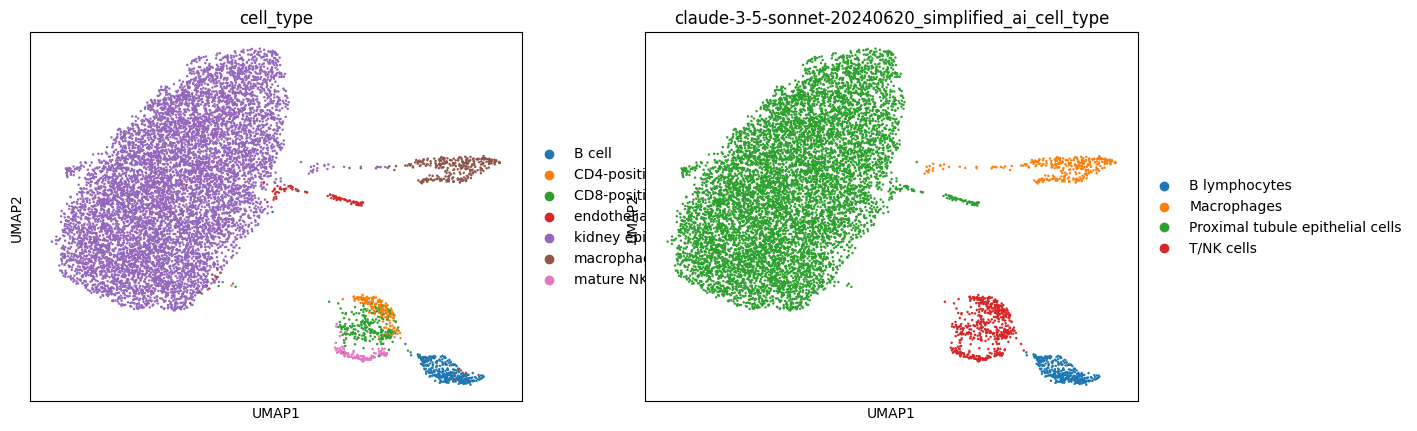

Plotting UMAP for key: liver


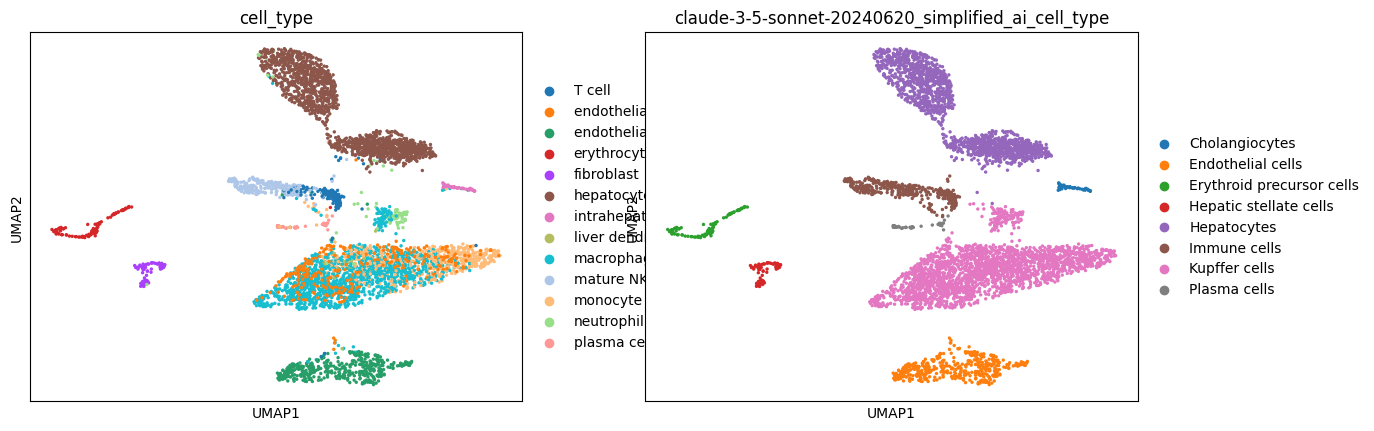

In [12]:
#View the results on a UMAP
adt.plot_umap_adata_dict(adata_dict, color=['cell_type', ai_label_column])

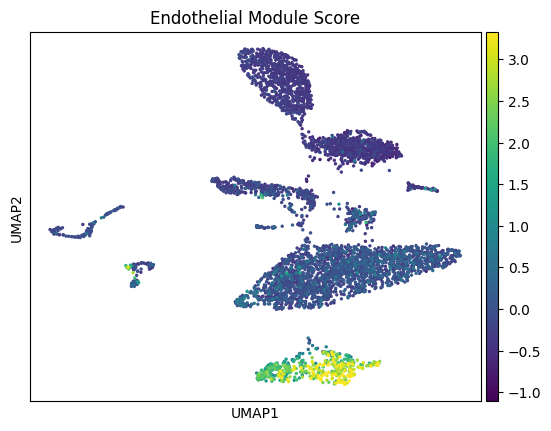

In [79]:
#Confirm an annotation using a marker gene score
endothelial_cell_markers = ["PECAM1", "VWF", "ENG", "CDH5", "FLT1"]
sc.tl.score_genes(adata_dict['liver'], gene_list=endothelial_cell_markers, score_name='Endothelial_Score')

# Plot UMAP (Kupffer Score)
sc.pl.umap(adata_dict['liver'], color='Endothelial_Score', title='Endothelial Module Score', vmax='p99', return_fig=False)

In [13]:
#Merge the adata_dict
adata = adt.concatenate_adata_dict(adata_dict)

In [14]:
adata

AnnData object with n_obs × n_vars = 14648 × 60656
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'leiden', 'claude-3-5-sonnet-20240620_ai_cell_type', 'claude-3-5-sonnet-20240620_simplified_ai_cell_type'
    obsm: 'X_pca', 'X_umap'

In [15]:
#unify the labels from the different adata in the adata_dict (i.e. use an LLM to merge categories like 'Macrophage' and 'macrophages.')
#this allows calculation of kappa
manual_cell_type_col = 'cell_type'
label_map_with_manual = adt.ensure_label_consistency_adata(adata, [ai_label_column, manual_cell_type_col], simplification_level='unified', new_col_prefix='unified')

In [95]:
label_map_with_manual

{'hepatocytes': 'Hepatocyte',
 'b lymphocytes': 'B Cell',
 'erythroid precursor cells': 'Erythroid Cell',
 'kidney epithelial cell': 'Epithelial Cell',
 'plasma cells': 'Plasma Cell',
 'endothelial cell': 'Endothelial Cell',
 'kupffer cells': 'Kupffer Cell',
 'hepatocyte': 'Hepatocyte',
 'immune cells': 'Immune Cell',
 'macrophage': 'Macrophage',
 'endothelial cell of hepatic sinusoid': 'Endothelial Cell',
 'plasma cell': 'Plasma Cell',
 'intrahepatic cholangiocyte': 'Cholangiocyte',
 'monocyte': 'Monocyte',
 'cholangiocytes': 'Cholangiocyte',
 'hepatic stellate cells': 'Hepatic Stellate Cell',
 'b cell': 'B Cell',
 'liver dendritic cell': 'Dendritic Cell',
 'erythrocyte': 'Erythrocyte',
 'neutrophil': 'Neutrophil',
 'mature nk t cell': 'NK T Cell',
 'proximal tubule epithelial cells': 'Epithelial Cell',
 'endothelial cells': 'Endothelial Cell',
 'cd4positive helper t cell': 'T Cell',
 't cell': 'T Cell',
 'fibroblast': 'Fibroblast',
 'macrophages': 'Macrophage',
 'tnk cells': 'NK T Ce

In [16]:
#get unified cols
unified_cell_types = adt.get_adata_columns(adata, col_contains=['unified'])
unified_cell_types

['unified_claude-3-5-sonnet-20240620_simplified_ai_cell_type',
 'unified_cell_type']

In [17]:
#assess accuracy compared to manual (for benchmarking)
label_agreement_binary = adt.ai_compare_cell_type_labels_pairwise(adata, [unified_cell_types[0]], [unified_cell_types[1]], new_col_prefix='binary_agreement', comparison_level='binary')
label_agreement_categorical = adt.ai_compare_cell_type_labels_pairwise(adata, [unified_cell_types[0]], [unified_cell_types[1]], new_col_prefix='categorical_agreement', comparison_level='categorical')

In [99]:
label_agreement_binary

{('unified_claude-3-5-sonnet-20240620_simplified_ai_cell_type',
  'unified_cell_type'):                      col1              col2 raw_agreement  agreement
 0         Epithelial Cell   Epithelial Cell           yes          1
 1                  B Cell            B Cell           yes          1
 2               NK T Cell            T Cell           yes          1
 3         Epithelial Cell  Endothelial Cell            no          0
 4              Macrophage        Macrophage           yes          1
 5               NK T Cell         NK T Cell           yes          1
 6         Epithelial Cell        Macrophage            no          0
 7         Epithelial Cell            T Cell            no          0
 8                  B Cell        Macrophage            no          0
 9              Macrophage   Epithelial Cell            no          0
 10        Epithelial Cell            B Cell            no          0
 11              NK T Cell            B Cell            no          0
 12

In [100]:
label_agreement_categorical

{('unified_claude-3-5-sonnet-20240620_simplified_ai_cell_type',
  'unified_cell_type'):                      col1              col2  raw_agreement  agreement
 0         Epithelial Cell   Epithelial Cell  perfect match          2
 1                  B Cell            B Cell  perfect match          2
 2               NK T Cell            T Cell  partial match          1
 3         Epithelial Cell  Endothelial Cell       no match          0
 4              Macrophage        Macrophage  perfect match          2
 5               NK T Cell         NK T Cell  perfect match          2
 6         Epithelial Cell        Macrophage       no match          0
 7         Epithelial Cell            T Cell       no match          0
 8                  B Cell        Macrophage       no match          0
 9              Macrophage   Epithelial Cell       no match          0
 10        Epithelial Cell            B Cell       no match          0
 11              NK T Cell            B Cell       no match  

In [18]:
#get the agreement columns
binary_agreement_cols = adt.get_adata_columns(adata, col_contains = ['binary_agreement'])
categorical_agreement_cols = adt.get_adata_columns(adata, col_contains = ['categorical_agreement'])

In [21]:
#change scale of categorical label agreement cols from 0 to 1 (raw has values 0, 1, and 2)
adata.obs[categorical_agreement_cols] = adata.obs[categorical_agreement_cols]/2

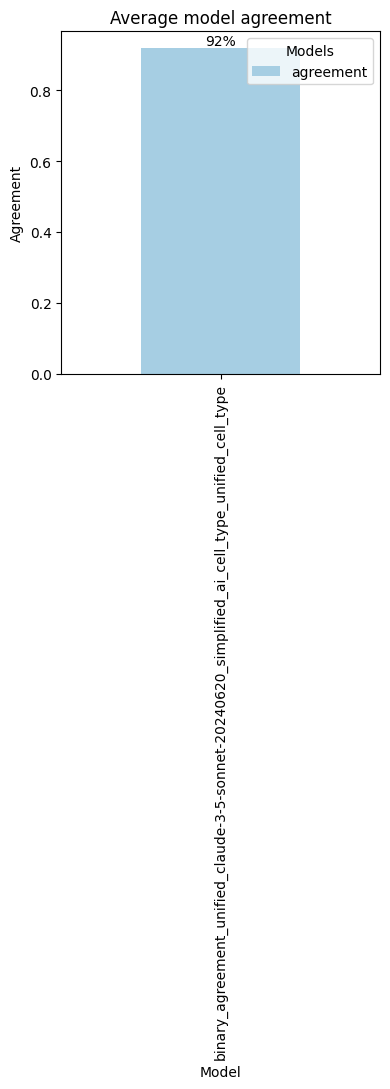

In [91]:
#plot the agreement at the binary level
agreement_plot_overall_binary = adt.plot_model_agreement(adata, group_by=manual_cell_type_col, sub_group_by='tissue', model_cols=binary_agreement_cols, granularity=0)

#clean plot up for display
import matplotlib.pyplot as plt
def set_xticks_rotation_and_resize(fig_ax_tuple):
    fig, ax = fig_ax_tuple
    fig.set_size_inches((4, 11))
    fig.tight_layout()  # Adjust layout to fit the new size
    
    # Rotate x-axis tick labels
    for label in ax.get_xticklabels():
        label.set_rotation(90)
    
    # Check if legend exists and update labels if necessary
    legend = ax.get_legend()
    if legend:
        # Define label mapping
        label_mapping = {'0.0': 'No', '0.5': 'Partial', '1.0': 'Perfect'}
        
        # Iterate over legend texts and update if in mapping
        for text in legend.get_texts():
            original_label = text.get_text()
            new_label = label_mapping.get(original_label, original_label)
            text.set_text(new_label)
set_xticks_rotation_and_resize(agreement_plot_overall_binary)

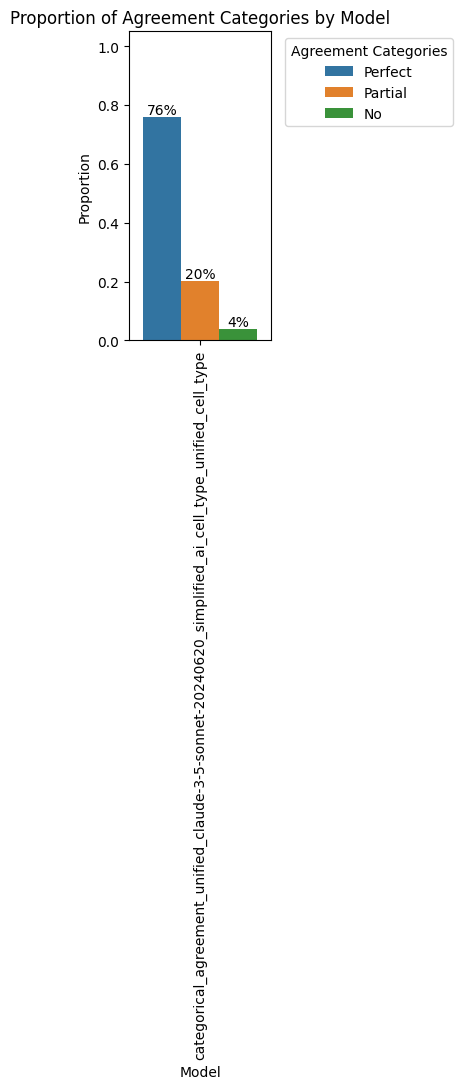

In [86]:
#plot the agreement at the binary level
agreement_plot_overall_categorical = adt.plot_model_agreement_categorical(adata, group_by=manual_cell_type_col, sub_group_by='tissue', model_cols=categorical_agreement_cols, granularity=0)

#clean plot up for display
set_xticks_rotation_and_resize(agreement_plot_overall_categorical)

In [77]:
#calculate kappa
kappa = adt.kappa_adata(adata, unified_cell_types)
kappa

{'pairwise': {('unified_claude-3-5-sonnet-20240620_simplified_ai_cell_type',
   'unified_cell_type'): 0.6337789381249733,
  ('unified_cell_type',
   'unified_claude-3-5-sonnet-20240620_simplified_ai_cell_type'): 0.6337789381249733},
 'average_pairwise': {'unified_claude-3-5-sonnet-20240620_simplified_ai_cell_type': 0.6337789381249733,
  'unified_cell_type': 0.6337789381249733},
 'fleiss': 0.6282839565968413}

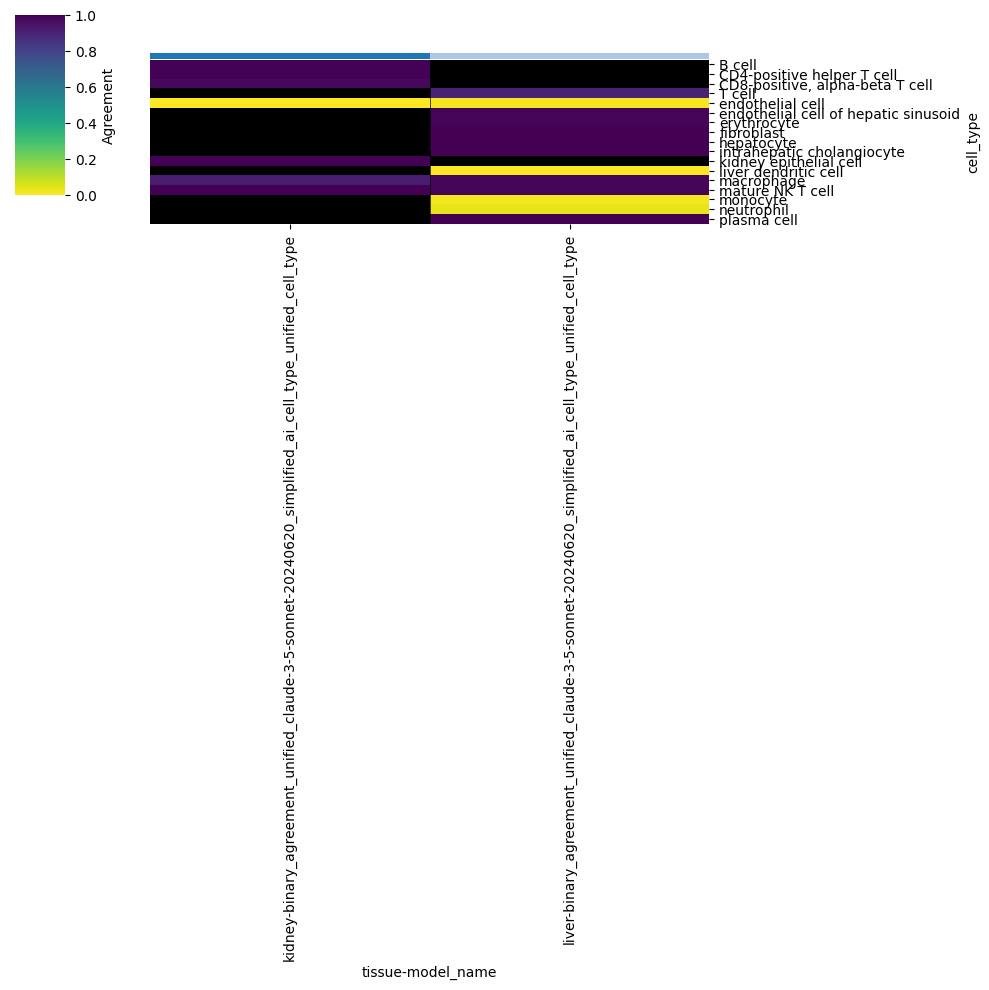

In [97]:
#Visualize agreement at the tissue-celltype level
agreement_plot_overall_binary = adt.plot_model_agreement(adata, group_by=manual_cell_type_col, sub_group_by='tissue', model_cols=binary_agreement_cols, granularity=2)

In [ ]:
#write the adata
path_to_write_adata = 'your-path-here.h5ad'
adata.write(path_to_write_adata)